## <center><strong>Notebook describtion & Our <span style= 'color: #51fcc6'>Questions</span>

In this notebook we are going to create the charts that we are going to use in the final pdf report and the tools we are going<br>
to use are matplotlib and seaborn.

#### **Questions we are going to awnser:**
1. How many jobs are available per country and per profession on Likedin.

2. What's the ratio between people who earned money on UpWork Vs Guru.

3. Average salary per profession and per country on LinkedIn.

4. What's Top 5 people in earnings amount most frequent words in thier describtions.<sub> *(In upwork)</sub>

5. What's Worst 5 people in earnings amount most frequent words in thier describtions.<sub> *(In upwork)</sub>

6. What are the most appending skills in the job titels per profession.<sub> *(In upwork & LinkedIn)</sub>

7. What are the Top 10 skills in earnings. <sub> *(In upwork & LinkedIn)</sub>

8. Correlation between Earnings amount, Years of Exp, Hour rate & Feedback in Upwork.

9. Does the Consultations offers affect the Earnings amount strongly.

10. Top 3 countries in total freelancers earnings Vs Top 3 countries in freelancers count <sub> *(In upwork & guru)</sub>

11. Jobs count per Jobs location per profession.

12. Where are the most job loactions in general per profession.

13. What's the average salary per proffision & per country.

14. What's the most common Employment type per data jobs in general.

15. Jobs count vs listing dates per proffision to see thier growth trends.

16. most common Earning abount, hour rate, exp years per proffision in Upwork.

#### **Important note:**
I am going to use  **`pandasql`** to read the data from the dfs so I can create plots more easly using SQL<br>
queries inside python.

## <center><strong>Importing the <span style= 'color: #48e0dc'>Packeges 

In [91]:
import os
import warnings
import matplotlib
import pandasql           as ps
import pandas             as pd
import numpy              as np
import seaborn            as sns
import matplotlib.pyplot  as plt

from google.cloud         import bigquery
from wordcloud            import WordCloud
from collections          import Counter
from matplotlib.colors    import ListedColormap

In [116]:
%matplotlib inline
plt.rcParams['font.family'] = 'Candara'

warnings.filterwarnings('ignore')

credentials_path :str = '../credentials.json'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = credentials_path

FONT             :int  = 20
COLORS           :list = ['#51fcc6', '#48e0dc', '#5cd3f7', '#4895e0', '#517afc']
GREYS            :list = ['#999999', '#777777', '#555555']

NUMERICS         :list = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64',
                          'uint16', 'uint32', 'uint64']

## <center><strong>Loading the data & basic data <span style= 'color: #5cd3f7'>Cleaning

In [51]:
project_id :str = 'data-jobs-analysis-db'
dataset_id :str = 'data_jobs_analysis_db'

query_pandas  = lambda q: ps.sqldf(q, globals())
client        = bigquery.Client(project= project_id)

linkedin_jobs    = client.query(f'SELECT * FROM {dataset_id}.linkedin_jobs;').to_dataframe()
upwork_profiles  = client.query(f'SELECT * FROM {dataset_id}.upwork_profiles;').to_dataframe()
guru_profiles    = client.query(f'SELECT * FROM {dataset_id}.guru_profiles;').to_dataframe()

In [52]:
cm = sns.light_palette(COLORS[0], as_cmap=True)

linkedin_jobs.drop(['describtion', 'jobs_links', 'jobs_titles', 'skills']
                   , axis= 1).sample(5).style.background_gradient(cmap= cm)

,jobs_locations,listing_dates,companies_names,location_type,employment_type,industry,reqierd_credential,country,job_title,total_jobs,salary,programming_lang,exp_years
798,"Oakland, CA",None,STIIIZY,Remote,FULL_TIME,Manufacturing,high school,European Union,Data entry,264000,21.000000,[],3.000000
2219,"San Francisco, CA",2023-03-28,MoTek Technologies,From office,OTHER,Staffing and Recruiting,bachelor degree,European Union,Data engineer,39000,35.000000,['scala'],3.000000
76,"San Francisco, CA",2023-07-07,Meta,Remote,FULL_TIME,"Technology, Information and Internet",bachelor degree,United States,ML developer,2000,nan,['scala' 'java' 'c++' 'python'],3.000000
2832,"Saratoga, CA",2023-03-21,Recruiting from Scratch,Remote,FULL_TIME,Staffing and Recruiting,bachelor degree,United States,ML developer,2000,185000.000000,['scala' 'python'],nan
78,"Menlo Park, CA",2023-07-07,Meta,Remote,FULL_TIME,"Technology, Information and Internet",bachelor degree,United States,ML developer,2000,nan,['scala' 'java' 'c++' 'python'],4.000000


In [53]:
cm = sns.light_palette(COLORS[2], as_cmap=True)

upwork_profiles.drop(['describtion', 'skills']
                   , axis= 1).sample(5).style.background_gradient(cmap= cm)

,Unnamed__0,feedback,name,job_title,country,consultations_offers,data_job_title,new_columns,earnings_amount_new,hour_rate_new,exp_years
891,,89.000000,Arslan M.,"Machine Learning Expert (Computer Vision, Time Series Forecasting)",Pakistan,Doesn't offer consultations,Data Engineering,"{'earnings_amount_new': 1000, 'hour_rate_new': 15.0}",1000,15.000000,2.000000
586,,98.000000,Evelyn P.,Data Entry Specialist / Virtual Assistant,Philippines,Doesn't offer consultations,Data entry,"{'earnings_amount_new': 40000, 'hour_rate_new': 7.0}",40000,7.000000,nan
9,,89.000000,Mohsin A.,Data Analysis I Visualization/ Automations - EXCEL I POWERBI I PYTHON,Pakistan,Offers consultations,Data Analyst,"{'earnings_amount_new': None, 'hour_rate_new': 18.0}",,18.000000,nan
523,,100.000000,Tamjeed A.,Data Maven | Virtual Assistant : Your Business Catalyst,India,Doesn't offer consultations,Data Engineering,"{'earnings_amount_new': 30000, 'hour_rate_new': 15.0}",30000,15.000000,5.000000
774,,97.000000,Ahsan U.,Power BI|Google Data Studio|Tableau|Scraping|SQL|Python/Excel/VBA/,Pakistan,Doesn't offer consultations,Data Engineering,"{'earnings_amount_new': 100000, 'hour_rate_new': 40.0}",100000,40.000000,nan


In [54]:
cm = sns.light_palette(COLORS[4], as_cmap=True)

guru_profiles.drop(['describtion', 'skills']
                   , axis= 1).sample(5).style.background_gradient(cmap= cm)

,Unnamed__0,name,job_title,addresse,minimum_pay,data_job_title,new_columns,earnings_amount_new,hour_rate_new,feedback_new
96,,Steve Y.,"AI, Machine Learning, ChatGPT Dev","Lakeville, Minnesota, United States",700.000000,Machine Learning,"{'earnings_amount_new': 240221, 'feedback_new': 992.0, 'hour_rate_new': 70.0}",240221,70.000000,992.000000
1749,,Haputhanthrige Dona Kamani Gunase,Data Entry,"Colombo, Western, Sri Lanka",500.000000,Data entry,"{'earnings_amount_new': 0, 'feedback_new': 0.0, 'hour_rate_new': 10.0}",0,10.000000,0.000000
1312,,Prashant Y,Machine Learning Engineer/Trainer,"Pune, Maharashtra, India",30.000000,Machine Learning,"{'earnings_amount_new': 0, 'feedback_new': 0.0, 'hour_rate_new': 15.0}",0,15.000000,0.000000
1763,,Yuri Lacerda,Data Scientist / Data Engineer,"Sao Paulo, Sao Paulo, Brazil",500.000000,Data Engineering,"{'earnings_amount_new': 0, 'feedback_new': 0.0, 'hour_rate_new': 45.0}",0,45.000000,0.000000
1690,,Adhy Wijaya,QuickBooks Data Entry,"Trenggalek, East Java, Indonesia",100.000000,Data entry,"{'earnings_amount_new': 9722, 'feedback_new': 100.0, 'hour_rate_new': 15.0}",9722,15.000000,100.000000


#### **Basic cleaning:**

In [55]:
def tucky_method(array: np.array, indecies= True) -> np.array:
    """
    This function works with any list-like numerical object
    (don't work with pandas series's) and returns the indexes
    of the found outliers in the array.
    
    :Params: Takes only the series.
    :Returns: S list of the outliers indexes.
    """
    
    Q3 = np.quantile(array, 0.75)
    Q1 = np.quantile(array, 0.25)
    IQR = Q3 - Q1
    
    upper_range = Q3 + (IQR * 1.5)
    lower_range = Q1 - (IQR * 1.5)
    
    outliers = [x for x in array if ((x < lower_range) | (x > upper_range))]
    print(f"Found {len(outliers)} outliers from {len(array)} length series!")
    
    return outliers

In [65]:
upwork_profiles.drop(['Unnamed__0', 'new_columns'], axis= 1, inplace= True)
guru_profiles.drop(['Unnamed__0', 'new_columns'], axis= 1, inplace= True)

linkedin_jobs.drop(['jobs_links'], axis= 1, inplace= True)

linkedin_jobs['salary'] = linkedin_jobs['salary'].where((linkedin_jobs.salary < 70) |
                                                        (linkedin_jobs.salary > 10_000) &
                                                        (linkedin_jobs.salary > 5))

per_hour_or_year_map = lambda salary: 'per year' if salary > 10_000 else 'per hour' if salary < 100 else np.nan
linkedin_jobs['per_hour_or_year'] = linkedin_jobs['salary'].apply(per_hour_or_year_map)

In [57]:
outliers = tucky_method(linkedin_jobs[linkedin_jobs['per_hour_or_year'] == 'per year']['salary'].to_numpy())
outliers_indexes = np.array(*np.where(np.isin(linkedin_jobs['salary'], outliers)))
linkedin_jobs = linkedin_jobs.drop(outliers_indexes)

# outliers = z_score(linkedin_jobs['salary'].to_numpy())
# outliers_indexes = np.array(*np.where(np.isin(base_videos['viewCount'], outliers)))
# temp_base_videos = base_videos.drop(outliers_indexes)


Found 77 outliers from 964 length series!


## <center><strong><span style= 'color: #5cd3f7'>Visualizing</span> the data (part 1)

In [58]:
def add_bar_labels(x,y, ax, scaler= 0):
    for i in range(len(x)):
        ax.text(i, y[i] + scaler , '{:,}'.format(y[i]), ha = 'center')

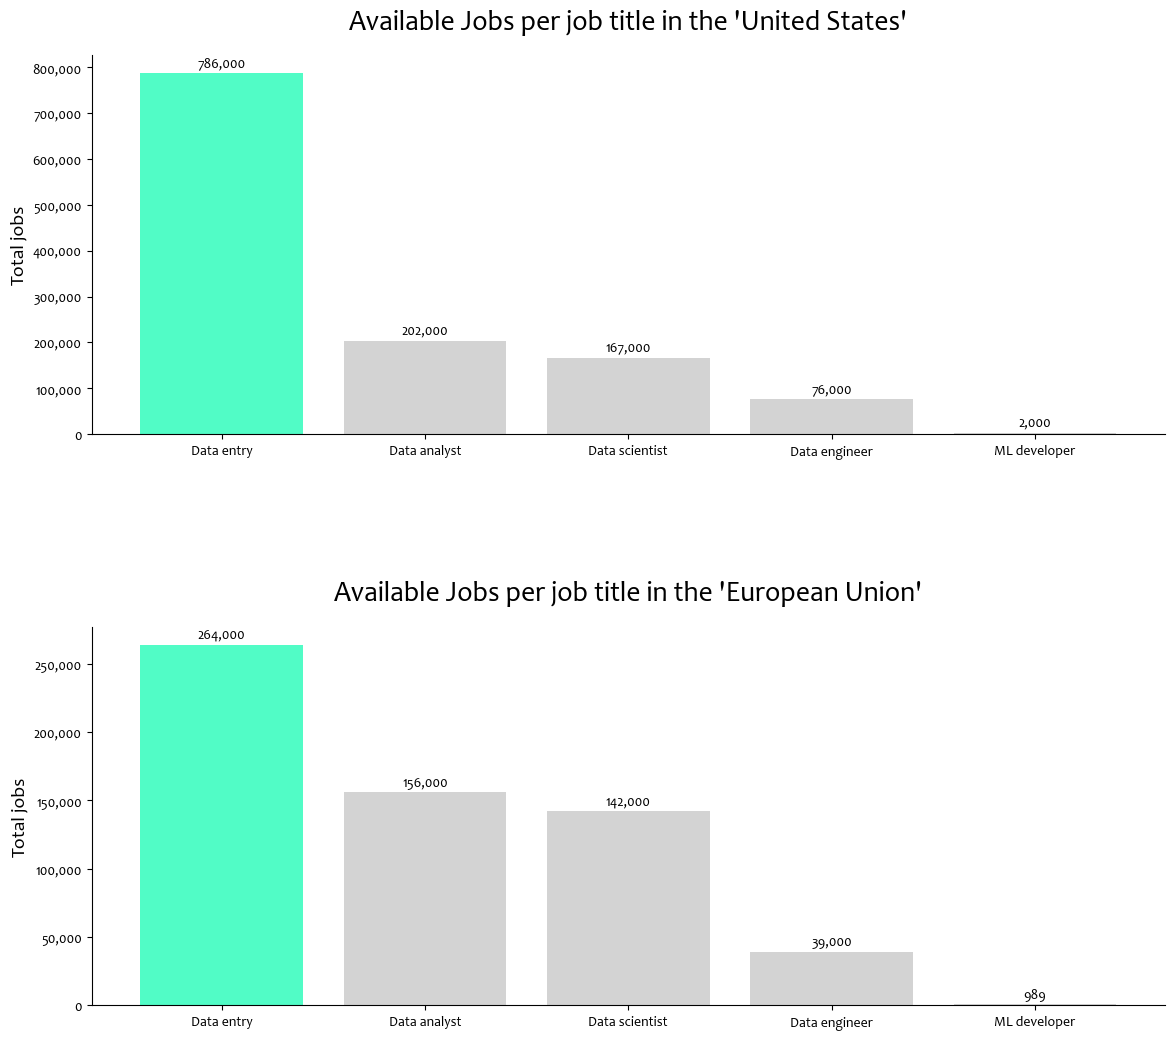

In [59]:
fig, (ax1, ax2) = plt.subplots(nrows= 2)

countries = ['\'United States\'', '\'European Union\'']

colors_temp = [COLORS[0]] * 1
colors_temp += ['lightgrey'] * 5

for ax, country in zip([ax1, ax2], countries):
    
    data = query_pandas(f'''SELECT total_jobs,
                                 job_title,
                                 country
                           FROM linkedin_jobs
                           WHERE country = {country}
                           GROUP BY job_title
                           ORDER BY total_jobs DESC;''')
    
    ax.bar(x=      data['job_title'],
           height= data['total_jobs'],
           color=  colors_temp)
    
    ax.spines[['right', 'top']].set_visible(False)

    ax.get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    ax.set_title(f'Available Jobs per job title in the {country}', fontsize= FONT, pad= 19)
    ax.set_ylabel('Total jobs', fontsize= FONT * 3.5/5)
    
    if ax is ax1:
        add_bar_labels(data['job_title'], data['total_jobs'], ax, scaler= 15000)
        
    if ax is ax2:
        add_bar_labels(data['job_title'], data['total_jobs'], ax, scaler= 5000)

        
fig.tight_layout(h_pad=0.5, w_pad=5)
fig.set_size_inches(13, 12)
plt.show()

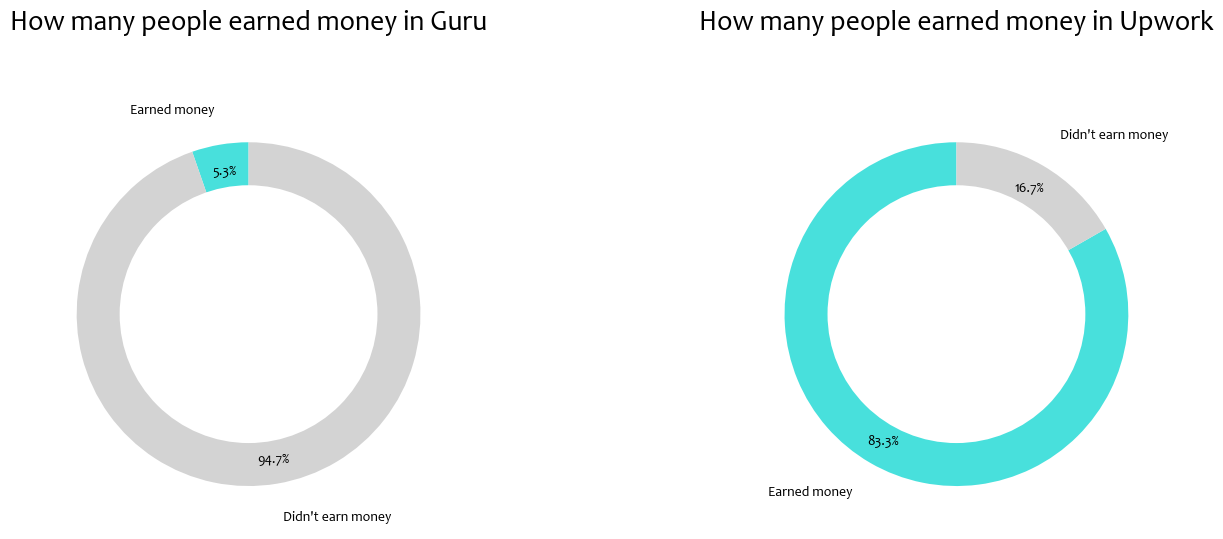

In [70]:
fig, (ax1, ax2) = plt.subplots(ncols=2)

platforms   : list = ['guru', 'upwork']
labels      : list = ['Earned money', 'Didn\'t earn money']
colors_temp : list = [COLORS[1], 'lightgrey']
explode     : list = [0.2, 0.2]

for ax, platform in zip([ax1, ax2], platforms):
    # The first row in the queried table below contains the people who have earned money count
    data = query_pandas(f'''SELECT COUNT(*) AS total_profiles
                           FROM {platform}_profiles
                           WHERE earnings_amount_new > 0
                           
                           UNION ALL
                           
                           SELECT COUNT(*) AS total_profiles
                           FROM {platform}_profiles
                           WHERE earnings_amount_new IS NULL OR 
                                 earnings_amount_new = 0;''')


    # Plot the pie chart on the current axis
    # ax.pie(counts, labels=labels, autopct='%2.1f%%', pctdistance=0.85, labeldistance=1.2, colors= colors_temp)
    
    ax.pie(data['total_profiles'], labels=labels, autopct='%2.1f%%',
           pctdistance=0.85, labeldistance=1.2, colors=colors_temp,
           startangle=90)
    
    ax.set_title(f'How many people earned money in {platform.title()}', fontsize= FONT, pad= 50)
                 
    centre_circle = plt.Circle((0, 0), 0.75, fc='white')
    ax.add_artist(centre_circle)

fig.tight_layout(w_pad=7)
fig.set_size_inches(13, 10)
plt.show()

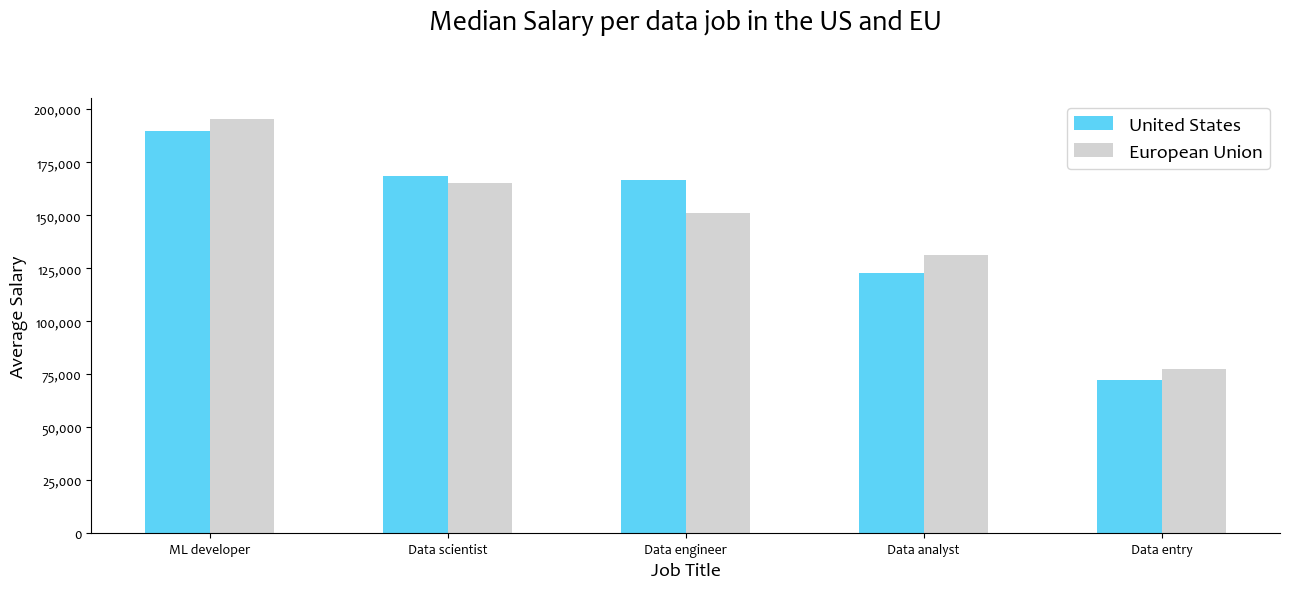

In [71]:
fig = plt.figure()
ax = fig.add_subplot(111)

width = 0.27

data = query_pandas(f'''SELECT AVG(salary) AS avg_salary,
                               country,
                               job_title

                        FROM linkedin_jobs
                        WHERE salary > 100 
                        GROUP BY country, job_title
                        ORDER BY avg_salary DESC;''')

us_data = data[data['country'] == 'United States']
eu_data = data[data['country'] == 'European Union']

positions_us = range(len(us_data))
positions_eu = [pos + width for pos in positions_us]


ax.bar(positions_us, us_data['avg_salary'], width,
       align='center', label='United States',
       color= COLORS[2])

ax.bar(positions_eu, eu_data['avg_salary'], width,
       align='center', label='European Union',
       color= 'lightgrey')


ax.spines[['right', 'top']].set_visible(False)
ax.set_xticks([pos + width/2 for pos in positions_us])
ax.set_xticklabels(us_data['job_title'], ha='center')

ax.set_title(f'Median Salary per data job in the US and EU', fontsize= FONT, pad= 50)
ax.set_xlabel('Job Title',      fontsize= FONT * 3.5/5)
ax.set_ylabel('Average Salary', fontsize= FONT * 3.5/5)


ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax.legend(fontsize="14")
fig.set_size_inches(13, 6)
fig.tight_layout()
plt.show()

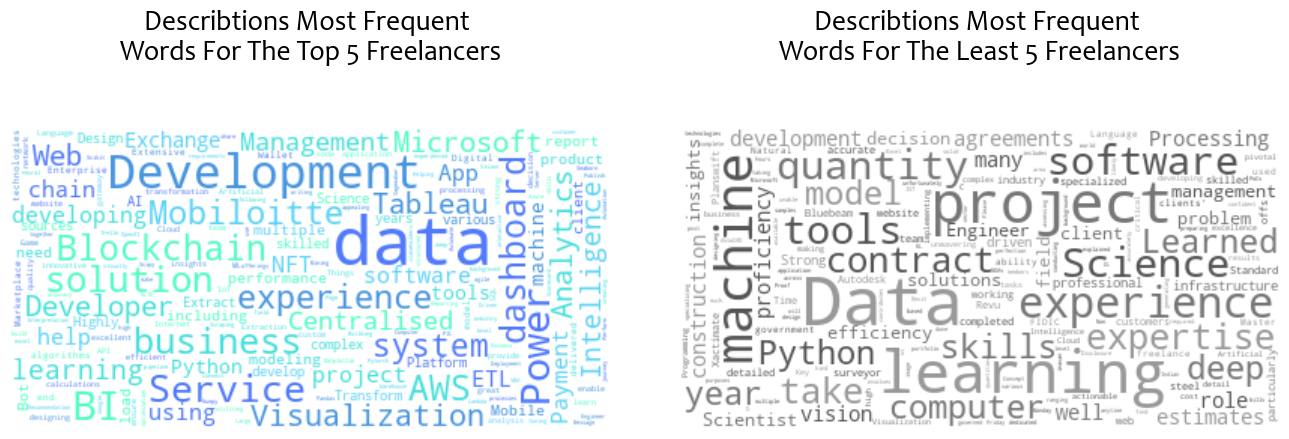

In [117]:
fig, (ax1, ax2) = plt.subplots(ncols=2)

cmap      = ListedColormap(COLORS)
grey_cmap = ListedColormap(GREYS)

top_5_describtions = query_pandas('''SELECT describtion
                                     FROM upwork_profiles
                                     WHERE earnings_amount_new IS NOT NULL
                                     ORDER BY earnings_amount_new DESC
                                     LIMIT 5;''')['describtion'].str.cat(sep= ' ')

least_5_describtions = query_pandas('''SELECT describtion
                                       FROM upwork_profiles
                                       WHERE earnings_amount_new IS NOT NULL
                                       ORDER BY earnings_amount_new
                                       LIMIT 5;''')['describtion'].str.cat(sep= ' ')

wordcloud_ax1 = WordCloud(collocations= False, background_color= 'white',
                      max_font_size= 45, colormap= cmap).generate(top_5_describtions)


wordcloud_ax2 = WordCloud(collocations= False, background_color= 'white',
                      max_font_size= 45, colormap= grey_cmap).generate(least_5_describtions)

ax1.set_title(f'Describtions Most Frequent \nWords For The Top 5 Freelancers', fontsize= FONT, pad= 50)
ax2.set_title(f'Describtions Most Frequent \nWords For The Least 5 Freelancers', fontsize= FONT, pad= 50)

ax1.imshow(wordcloud_ax1, interpolation='bilinear')
ax1.axis("off")

ax2.imshow(wordcloud_ax2, interpolation='bilinear')
ax2.axis("off")

fig.set_size_inches(13, 6)
plt.tight_layout(w_pad= 5)
plt.show()

In [96]:
query_pandas('''SELECT *
                FROM upwork_profiles
                WHERE earnings_amount_new IS NOT NULL
                ORDER BY earnings_amount_new
                LIMIT 5;''')

,describtion,feedback,name,job_title,country,consultations_offers,skills,data_job_title,earnings_amount_new,hour_rate_new,exp_years
0,With more than 20 years of industry experience...,NaN,Sujith M.,Machine Learning Professionals,India,Doesn't offer consultations,"['Machine Learning', 'Deep Learning', 'OpenCV'...",Machine Learning,50,20.0,NaN
1,I have a solid background as a quantity survey...,NaN,Israr A.,"Civil engineering, Quantity take-off, Designin...",Pakistan,Offers consultations,"['Offers consultations', 'Cost Estimate', 'Aut...",Data Engineering,55,20.0,12.0
2,I am TANZEEL ABBAS . I am working in the field...,NaN,Tanzeel A.,"Machine Learning Engineer, Data Scientist, Dat...",Pakistan,Doesn't offer consultations,"['Machine Learning Model', 'Keras', 'PyTorch',...",Machine Learning,62,10.0,3.0
3,As a highly skilled and accomplished freelance...,100.0,Birender S.,Data Scientist,United States,Doesn't offer consultations,"['Data Science', 'Machine Learning', 'Python',...",Data scientist,66,100.0,NaN
4,Data Scientist | Machine Learning | Software D...,NaN,Hadi S.,Data Scientist,Denmark,Doesn't offer consultations,"['Data Science', 'Machine Learning', 'Python',...",Data scientist,78,60.0,NaN
